# ÁSZF Érthetőség Predikciós Modell

A projekt célja egy NLP modell létrehozása, amely 1-től 5-ig terjedő skálán megbecsüli jogi szövegrészletek érthetőségét.

## Főbb lépések:
1. **Adatbetöltés**: Címkézett JSON adatok beolvasása.
2. **Jellemzők kinyerése (Feature Engineering)**: Szöveges jellemzők (olvashatósági indexek, jogi terminusok stb.) előállítása.
3. **Alapmodell (Baseline)**: Ordinális logisztikus regresszió tanítása a kinyert jellemzőkön.
4. **Transformer Modell**: Egyéni CORAL fejjel ellátott transzformer modell (pl. `SZTAKI/HuBERT`) finomhangolása.
5. **Értékelés**: Modellek összehasonlítása (MAE, QWK).
6. **Hibaanalízis**: A téves predikciók vizsgálata.

In [1]:
# Ha nem engedi akkor más kell
!git clone https://huggingface.co/huspacy/hu_core_news_md

fatal: destination path 'hu_core_news_md' already exists and is not an empty directory.


In [2]:
!pip install "hu_core_news_md\hu_core_news_md-3.8.1-py3-none-any.whl"

Processing c:\users\galb1\documents\melytanulas\hu_core_news_md\hu_core_news_md-3.8.1-py3-none-any.whl
hu-core-news-md is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [3]:
# 1. Importok és Konfiguráció
import os, re, json, math, random
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, confusion_matrix, cohen_kappa_score
from sklearn.preprocessing import StandardScaler
from mord import LogisticAT
import spacy
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Backbone és tréning konfiguráció
MODEL_NAME = 'SZTAKI-HLT/hubert-base-cc'  # vissza a működő HuBERT-re
MAX_LEN = 256
BATCH_SIZE = 8
EPOCHS = 8
LR = 2e-5
VAL_SIZE = 0.2
ANNOTATION_FILE = 'granit_bank_cimkezes.json'
TEXT_FILE = 'granit_bank-penzforgalmi_szolgaltatasok_aszf.txt'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Magyar spaCy modell betöltése (lokális hu_core_news_md mappából)
local_model_path = "hu_core_news_md"
try:
    nlp = spacy.load(local_model_path)
    print(f'✓ Magyar spaCy modell betöltve lokális forrásból: {local_model_path}')
except Exception as e:
    print(f'⚠ Lokális modell betöltése sikertelen ({e}).')
    print('  Fallback: blank magyar modell (kevésbé pontos POS/NER)')
    nlp = spacy.blank('hu')
    if 'sentencizer' not in nlp.pipe_names:
        nlp.add_pipe('sentencizer')

print('Konfiguráció betöltve. Modell:', MODEL_NAME, '| Eszköz:', DEVICE)

c:\Users\galb1\Documents\melytanulas\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Magyar spaCy modell betöltve lokális forrásból: hu_core_news_md
Konfiguráció betöltve. Modell: SZTAKI-HLT/hubert-base-cc | Eszköz: cpu


# 2. Adatbetöltés és Előfeldolgozás

A címkézett adatok betöltése a JSON fájlból. A `load_annotation_json` függvény kinyeri a bekezdés szövegét és a hozzá tartozó numerikus címkét.

In [4]:
# Adatbetöltés + Haladó Feature Engineering (Label Studio formátum támogatás)

def load_annotation_json(path: str) -> pd.DataFrame:
    """
    Betölti a címkézési adatokat egy JSON fájlból és DataFrame-mé alakítja.
    Elvárt felépítés (Label Studio export): lista a task objektumokkal.
    - task['data']['text'] tartalmazza a bekezdés szövegét
    - task['annotations'][0]['result'][0]['value']['choices'][0] tartalmazza a label szöveget (pl. '3 - Közepes')
    A labelt az első számjegy alapján nyeri ki.
    Ha a fájl üres vagy hibás, üres DataFrame-et ad vissza.
    """
    p = Path(path)
    if not p.exists():
        print(f"Figyelem: A fájl nem található: {path}")
        return pd.DataFrame(columns=['task_id','paragraph_text','label_int','label_text'])
    raw = p.read_text(encoding='utf-8').strip()
    if not raw:
        print("Figyelem: A JSON fájl üres.")
        return pd.DataFrame(columns=['task_id','paragraph_text','label_int','label_text'])
    if not raw.startswith('['):  # ha véletlenül nem listaként mentették
        raw = f'[{raw}]'
    try:
        data = json.loads(raw)
    except json.JSONDecodeError as e:
        print('JSON decode hiba:', e)
        return pd.DataFrame(columns=['task_id','paragraph_text','label_int','label_text'])
    rows = []
    for task in data:
        text = task.get('data', {}).get('text', '').strip()
        ann_list = task.get('annotations', [])
        if not ann_list:
            continue
        ann = ann_list[0]
        result = ann.get('result', [])
        if not result:
            continue
        choice = result[0].get('value', {}).get('choices', [None])[0]
        if not choice:
            continue
        m = re.match(r'(\d)', str(choice))
        if not m:
            continue
        label_int = int(m.group(1))
        rows.append({
            'task_id': task.get('id'),
            'paragraph_text': text,
            'label_int': label_int,
            'label_text': choice
        })
    return pd.DataFrame(rows)

# Bővített jogi terminus lista
LEGAL_TERMS = [
    "szerződés","feltétel","jog","kötelezettség","felelősség","kártérítés","hatály","rendelkezés",
    "törvény","rendelet","bíróság","per","felmondás","biztosítás","ügyfél","jogosult","kötelezett",
    "igény","teljesítés","megszűnés","érvényesség","jogviszony","követelés","eljárás","határozat",
    "jogorvoslat","kikötés","megállapodás","szerződő","felek","szolgáltatás","ellenszolgáltatás",
    "jogosultság","kötelezettségvállalás","közjegyző","polgári","meghatalmazás","meghatalmazott"
]

# Jogi rövidítések
LEGAL_ABBREVIATIONS = ["ptk","kft","zrt","bt","áfa","ászf","gvh","mkeh","mnb","pkkr"]

VOWELS = "aáeéiíoóöőuúüű"

def count_syllables_hu(word):
    count = 0; in_grp = False
    for ch in word.lower():
        if ch in VOWELS:
            if not in_grp:
                count += 1; in_grp = True
        else:
            in_grp = False
    return max(1, count)

def extract_features(text):
    words = re.findall(r'\w+', text.lower())
    word_count = len(words)
    char_count = len(text)
    sentence_count = max(1, len(re.findall(r'[.!?]', text)))
    syllable_count = sum(count_syllables_hu(w) for w in words) if words else 0
    avg_words_per_sentence = word_count / sentence_count if sentence_count else 0
    avg_syllables_per_word = syllable_count / word_count if word_count else 0
    
    # Alapvető olvashatósági indexek
    flesch_score_hu = 206.835 - 1.015 * avg_words_per_sentence - 84.6 * avg_syllables_per_word if word_count else 0
    
    # Gunning Fog Index (magyarra adaptálva: komplex szavak = 3+ szótagú szavak)
    complex_words = sum(1 for w in words if count_syllables_hu(w) >= 3) if words else 0
    complex_word_ratio = complex_words / word_count if word_count else 0
    gunning_fog = 0.4 * (avg_words_per_sentence + 100 * complex_word_ratio) if word_count else 0
    
    # SMOG Index (magyarra adaptálva)
    smog_index = 1.0430 * math.sqrt(complex_words * (30 / sentence_count)) + 3.1291 if sentence_count and complex_words else 0
    
    # Type-Token Ratio (TTR) - szókincs változatosság
    unique_words = len(set(words)) if words else 0
    ttr = unique_words / word_count if word_count else 0
    
    # Jogi terminológia
    legal_term_ratio = sum(1 for w in words if w in LEGAL_TERMS) / word_count if word_count else 0
    legal_abbr_ratio = sum(1 for w in words if w in LEGAL_ABBREVIATIONS) / word_count if word_count else 0
    
    # Szóhossz jellemzők
    long_word_ratio = sum(1 for w in words if len(w) > 12) / word_count if word_count else 0
    avg_word_length = sum(len(w) for w in words) / word_count if word_count else 0
    
    # Szerkezeti jellemzők
    comma_count = text.count(',')
    semicolon_count = text.count(';')
    parenthesis_count = text.count('(') + text.count(')')
    comma_ratio = comma_count / word_count if word_count else 0
    parenthesis_ratio = parenthesis_count / sentence_count if sentence_count else 0
    uppercase_words = sum(1 for w in re.findall(r'\b[A-ZÁÉÍÓÖŐÚÜŰ]+\b', text))
    uppercase_ratio = uppercase_words / word_count if word_count else 0
    
    # spaCy elemzés (magyar modellel POS és dependency parsing)
    doc = nlp(text)
    num_entities = len(doc.ents) if doc.ents else 0
    pos_counts = doc.count_by(spacy.attrs.POS) if hasattr(spacy.attrs,'POS') else {}
    num_nouns = pos_counts.get(spacy.symbols.NOUN, 0) if hasattr(spacy.symbols,'NOUN') else 0
    num_verbs = pos_counts.get(spacy.symbols.VERB, 0) if hasattr(spacy.symbols,'VERB') else 0
    num_adjs  = pos_counts.get(spacy.symbols.ADJ, 0) if hasattr(spacy.symbols,'ADJ') else 0
    num_advs  = pos_counts.get(spacy.symbols.ADV, 0) if hasattr(spacy.symbols,'ADV') else 0
    pos_noun_ratio = num_nouns / word_count if word_count else 0
    pos_verb_ratio = num_verbs / word_count if word_count else 0
    pos_adj_ratio  = num_adjs  / word_count if word_count else 0
    pos_adv_ratio  = num_advs  / word_count if word_count else 0
    
    # Dependency parsing mélység
    depths = []
    for token in doc:
        d=0; cur=token
        while cur.head != cur and d < 100:
            d += 1; cur = cur.head
        depths.append(d)
    avg_dep_depth = float(np.mean(depths)) if depths else 0
    max_dep_depth = float(max(depths)) if depths else 0
    
    return {
        'char_count': char_count,
        'word_count': word_count,
        'sentence_count': sentence_count,
        'syllable_count': syllable_count,
        'avg_word_length': avg_word_length,
        'flesch_score_hu': flesch_score_hu,
        'gunning_fog': gunning_fog,
        'smog_index': smog_index,
        'ttr': ttr,
        'complex_word_ratio': complex_word_ratio,
        'legal_term_ratio': legal_term_ratio,
        'legal_abbr_ratio': legal_abbr_ratio,
        'long_word_ratio': long_word_ratio,
        'comma_ratio': comma_ratio,
        'parenthesis_ratio': parenthesis_ratio,
        'uppercase_ratio': uppercase_ratio,
        'num_entities': num_entities,
        'pos_noun_ratio': pos_noun_ratio,
        'pos_verb_ratio': pos_verb_ratio,
        'pos_adj_ratio': pos_adj_ratio,
        'pos_adv_ratio': pos_adv_ratio,
        'avg_dep_depth': avg_dep_depth,
        'max_dep_depth': max_dep_depth
    }

# Annotációk betöltése az új függvénnyel
df_labels = load_annotation_json(ANNOTATION_FILE)
if not df_labels.empty:
    print(f"Betöltött címkék száma: {len(df_labels)}")
    print("Címkék eloszlása:")
    print(df_labels['label_int'].value_counts().sort_index())
    print("\nAdatminta:")
    print(df_labels.head())
else:
    print("Nem sikerült adatokat betölteni. A további feature / modell lépések kihagyva amíg nincs adat.")

# Feature kinyerés csak ha van adat
if not df_labels.empty:
    feature_rows = [extract_features(t) for t in tqdm(df_labels['paragraph_text'], desc='Feature extract')] 
    df_feat = pd.DataFrame(feature_rows)
    df_processed = pd.concat([df_labels.reset_index(drop=True), df_feat], axis=1)
    print('Feature oszlopok:', list(df_feat.columns)[:8], '...')
    print(df_processed.head(3))

Betöltött címkék száma: 119
Címkék eloszlása:
label_int
1    14
2    12
3    28
4    43
5    22
Name: count, dtype: int64

Adatminta:
   task_id                                     paragraph_text  label_int  \
0      204  2.1.1. A Pénzforgalmi Keretszerződés alapján a...          2   
1      205  2.1.2. A Korlátozottan cselekvőképes kiskorú T...          2   
2      206  2.1.3. A Bank által a Bankszámla megnyitásának...          3   
3      207  2.1.4. Ha a gazdálkodó szervezet / egyéb szerv...          1   
4      208  2.1.5. Ha a gazdálkodó szervezet / egyéb szerv...          3   

                 label_text  
0         2-Nehezen érthető  
1         2-Nehezen érthető  
2  3-Többé/kevésbé megértem  
3  1-Nagyon nehezen érthető  
4  3-Többé/kevésbé megértem  


Feature extract: 100%|██████████| 119/119 [00:05<00:00, 20.08it/s]

Feature oszlopok: ['char_count', 'word_count', 'sentence_count', 'syllable_count', 'avg_word_length', 'flesch_score_hu', 'gunning_fog', 'smog_index'] ...
   task_id                                     paragraph_text  label_int  \
0      204  2.1.1. A Pénzforgalmi Keretszerződés alapján a...          2   
1      205  2.1.2. A Korlátozottan cselekvőképes kiskorú T...          2   
2      206  2.1.3. A Bank által a Bankszámla megnyitásának...          3   

                 label_text  char_count  word_count  sentence_count  \
0         2-Nehezen érthető        1158         135               9   
1         2-Nehezen érthető        1534         183              11   
2  3-Többé/kevésbé megértem        1211         144               5   

   syllable_count  avg_word_length  flesch_score_hu  ...  comma_ratio  \
0             391         7.400000       -53.416667  ...     0.051852   
1             534         7.262295       -56.916483  ...     0.043716   
2             424         7.263889   

# 4. Alapmodell (Baseline) - Ordinális Regresszió

Egy egyszerű, de hatékony alapmodellt tanítunk a kinyert jellemzőkön a `mord` csomag segítségével.

In [5]:
# 5. Baseline Ordinal Regression (LogisticAT) haladó feature-ökkel
if 'df_processed' in globals() and not df_processed.empty:
    # Frissítve, hogy az összes új feature-t használja
    baseline_feature_cols = [
        'char_count', 'word_count', 'sentence_count', 'syllable_count', 
        'avg_word_length', 'flesch_score_hu', 'gunning_fog', 'smog_index', 'ttr', 
        'complex_word_ratio', 'legal_term_ratio', 'legal_abbr_ratio', 
        'long_word_ratio', 'comma_ratio', 'parenthesis_ratio', 'uppercase_ratio', 
        'num_entities', 'pos_noun_ratio', 'pos_verb_ratio', 'pos_adj_ratio', 
        'pos_adv_ratio', 'avg_dep_depth', 'max_dep_depth'
    ]
    missing = [c for c in baseline_feature_cols if c not in df_processed.columns]
    if missing:
        print('Hiányzó feature oszlopok, baseline kihagyva:', missing)
    else:
        Xb = df_processed[baseline_feature_cols].values
        yb = df_processed['label_int'].values
        X_train_b, X_val_b, y_train_b, y_val_b = train_test_split(Xb, yb, test_size=VAL_SIZE, random_state=SEED, stratify=yb)
        scaler_b = StandardScaler()
        X_train_b = scaler_b.fit_transform(X_train_b)
        X_val_b = scaler_b.transform(X_val_b)
        baseline_model = LogisticAT(alpha=0.5)
        baseline_model.fit(X_train_b, y_train_b)
        preds_b = baseline_model.predict(X_val_b)
        mae_b = mean_absolute_error(y_val_b, preds_b)
        print(f'Baseline LogisticAT MAE: {mae_b:.4f}')
else:
    print('Baseline nem futtatható: df_processed hiányzik vagy üres.')

Baseline LogisticAT MAE: 1.1250


# 5. Transformer Modell (CORAL)

Egy neurális háló alapú modellt definiálunk, amely egy előtanított transzformert (pl. huBERT) használ, és egy CORAL (Cumulative Ordinal Ranking and Regression) kimeneti réteggel egészíti ki az ordinális klasszifikációhoz.

In [6]:
# 6. Adatkészlet és DataLoader a Transformerhez

# Definiáljuk az összes új feature oszlopot
advanced_feature_cols = [
    'char_count', 'word_count', 'sentence_count', 'syllable_count', 
    'avg_word_length', 'flesch_score_hu', 'gunning_fog', 'smog_index', 'ttr', 
    'complex_word_ratio', 'legal_term_ratio', 'legal_abbr_ratio', 
    'long_word_ratio', 'comma_ratio', 'parenthesis_ratio', 'uppercase_ratio', 
    'num_entities', 'pos_noun_ratio', 'pos_verb_ratio', 'pos_adj_ratio', 
    'pos_adv_ratio', 'avg_dep_depth', 'max_dep_depth'
]

class LegalDataset(Dataset):
    def __init__(self, df, tokenizer, max_len, feature_cols, feature_stats=None):
        self.texts = df['paragraph_text'].values
        self.labels = df['label_int'].values
        self.features = df[feature_cols].values if feature_cols else None
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.feature_stats = feature_stats

        if self.features is not None and self.feature_stats:
            means = np.array([self.feature_stats[col][0] for col in feature_cols])
            stds = np.array([self.feature_stats[col][1] for col in feature_cols])
            self.features = (self.features - means) / stds

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        item = {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }
        if self.features is not None:
            item['features'] = torch.tensor(self.features[idx], dtype=torch.float)
        else:
            item['features'] = torch.empty(0, dtype=torch.float)
        return item

def create_data_loader(df, tokenizer, max_len, batch_size, feature_cols, feature_stats=None, sampler=None):
    ds = LegalDataset(
        df=df,
        tokenizer=tokenizer,
        max_len=max_len,
        feature_cols=feature_cols,
        feature_stats=feature_stats
    )
    return DataLoader(ds, batch_size=batch_size, num_workers=0, sampler=sampler)

# --- CORAL Modell definíciója ---
NUM_CLASSES = 5

class CoralHead(nn.Module):
    def __init__(self, hidden_size, num_classes, extra_feat_dim=0, dropout=0.1, temperature=1.0):
        super().__init__()
        self.use_extra = extra_feat_dim > 0
        in_dim = hidden_size + extra_feat_dim if self.use_extra else hidden_size
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(in_dim, num_classes - 1)
        self.temperature = temperature
    def forward(self, cls_hidden, extra_feats=None):
        x = torch.cat([cls_hidden, extra_feats], dim=1) if self.use_extra and extra_feats is not None else cls_hidden
        x = self.dropout(x)
        logits = self.linear(x) / self.temperature
        probs = torch.sigmoid(logits)
        return probs, logits

class CoralModel(nn.Module):
    def __init__(self, model_name, num_classes=5, extra_feat_dim=0):
        super().__init__()
        self.base = AutoModel.from_pretrained(model_name)
        hidden_size = self.base.config.hidden_size
        self.head = CoralHead(hidden_size, num_classes, extra_feat_dim=extra_feat_dim)
    def forward(self, input_ids, attention_mask, extra_feats=None):
        outputs = self.base(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0]
        probs, logits = self.head(cls_output, extra_feats)
        return probs, logits

# Tokenizer + modell példányosítás extra feature dim alapján
extra_dim = len(advanced_feature_cols)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
coral_model = CoralModel(MODEL_NAME, num_classes=NUM_CLASSES, extra_feat_dim=extra_dim)
print('Transformer + CORAL modell betöltve. Extra feature dim:', extra_dim)

Transformer + CORAL modell betöltve. Extra feature dim: 23



[Fold 1/5] Train size=95 Val size=24
Fold 1 Epoch 1: TrainLoss=0.6052 ValLoss=0.5359 ValMAE=1.0000 QWK=0.0000
Fold 1 Epoch 2: TrainLoss=0.4972 ValLoss=0.4892 ValMAE=0.9583 QWK=0.2205
Fold 1 Epoch 3: TrainLoss=0.4424 ValLoss=0.4595 ValMAE=0.9167 QWK=0.3077
Fold 1 Epoch 4: TrainLoss=0.3791 ValLoss=0.4371 ValMAE=0.8750 QWK=0.3359
Fold 1 Epoch 5: TrainLoss=0.3286 ValLoss=0.4424 ValMAE=0.8333 QWK=0.3636
Fold 1 Epoch 6: TrainLoss=0.2856 ValLoss=0.4519 ValMAE=0.8750 QWK=0.2667
Fold 1 Epoch 7: TrainLoss=0.2532 ValLoss=0.4354 ValMAE=0.8750 QWK=0.3309
Fold 1 Epoch 8: TrainLoss=0.2465 ValLoss=0.4426 ValMAE=0.9167 QWK=0.2714
Early stopping fold 1
Fold 1 best MAE: 0.8333


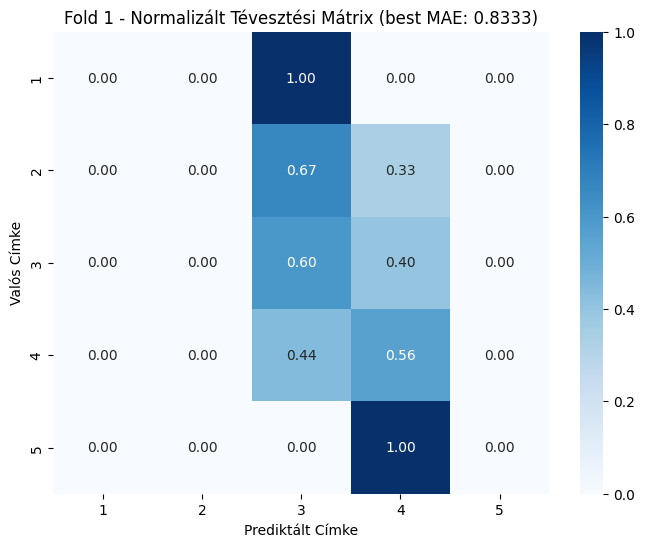


[Fold 2/5] Train size=95 Val size=24
Fold 2 Epoch 1: TrainLoss=0.5812 ValLoss=0.5217 ValMAE=1.0000 QWK=0.0000
Fold 2 Epoch 2: TrainLoss=0.4869 ValLoss=0.4695 ValMAE=0.9167 QWK=0.2727
Fold 2 Epoch 3: TrainLoss=0.4520 ValLoss=0.4556 ValMAE=0.8333 QWK=0.3182
Fold 2 Epoch 4: TrainLoss=0.3898 ValLoss=0.4231 ValMAE=0.8750 QWK=0.2901
Fold 2 Epoch 5: TrainLoss=0.3287 ValLoss=0.4432 ValMAE=0.7917 QWK=0.3830
Fold 2 Epoch 6: TrainLoss=0.2967 ValLoss=0.4121 ValMAE=0.8750 QWK=0.3309
Fold 2 Epoch 7: TrainLoss=0.2688 ValLoss=0.4420 ValMAE=0.7500 QWK=0.4085
Fold 2 Epoch 8: TrainLoss=0.2558 ValLoss=0.4454 ValMAE=0.7917 QWK=0.3077
Fold 2 best MAE: 0.7500


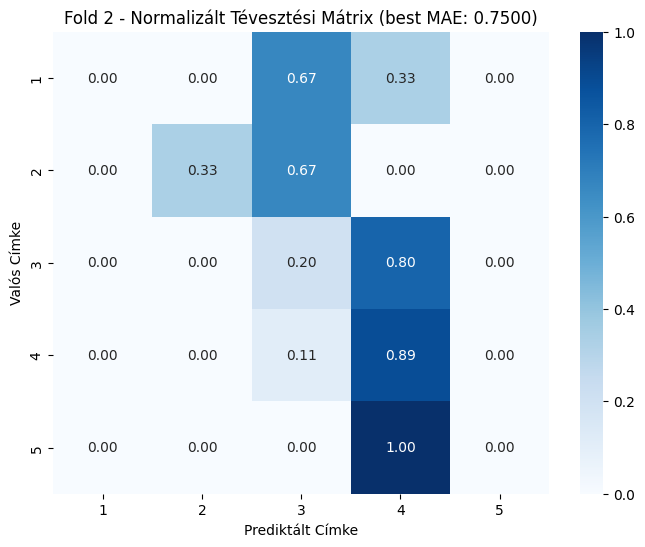


[Fold 3/5] Train size=95 Val size=24
Fold 3 Epoch 1: TrainLoss=0.5492 ValLoss=0.5295 ValMAE=0.9167 QWK=0.0735
Fold 3 Epoch 2: TrainLoss=0.4637 ValLoss=0.4781 ValMAE=0.9167 QWK=0.3077
Fold 3 Epoch 3: TrainLoss=0.4000 ValLoss=0.4487 ValMAE=0.8750 QWK=0.4276
Fold 3 Epoch 4: TrainLoss=0.3501 ValLoss=0.4358 ValMAE=0.8750 QWK=0.4276
Fold 3 Epoch 5: TrainLoss=0.2969 ValLoss=0.4263 ValMAE=0.8750 QWK=0.4508
Fold 3 Epoch 6: TrainLoss=0.2597 ValLoss=0.4273 ValMAE=0.8750 QWK=0.4508
Early stopping fold 3
Fold 3 best MAE: 0.8750


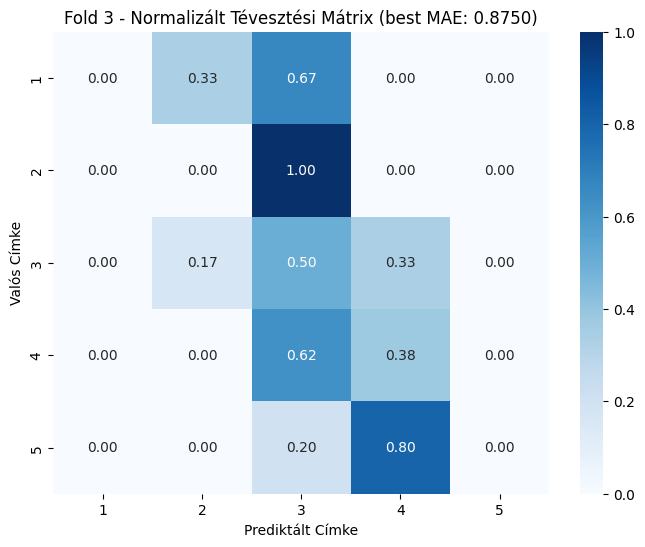


[Fold 4/5] Train size=95 Val size=24
Fold 4 Epoch 1: TrainLoss=0.5937 ValLoss=0.5081 ValMAE=0.8750 QWK=0.1868
Fold 4 Epoch 2: TrainLoss=0.4820 ValLoss=0.4469 ValMAE=0.8333 QWK=0.3130
Fold 4 Epoch 3: TrainLoss=0.4213 ValLoss=0.4209 ValMAE=0.7500 QWK=0.3684
Fold 4 Epoch 4: TrainLoss=0.3535 ValLoss=0.4035 ValMAE=0.7917 QWK=0.5534
Fold 4 Epoch 5: TrainLoss=0.2829 ValLoss=0.4625 ValMAE=0.8750 QWK=0.5335
Fold 4 Epoch 6: TrainLoss=0.2535 ValLoss=0.4215 ValMAE=0.8750 QWK=0.4141
Early stopping fold 4
Fold 4 best MAE: 0.7500


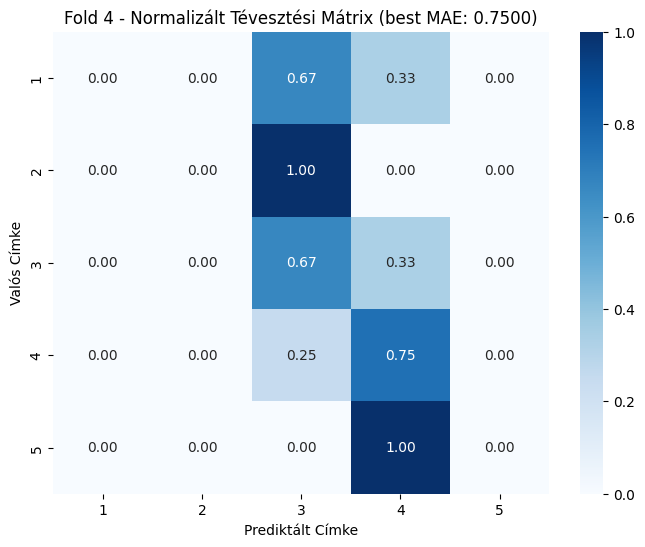


[Fold 5/5] Train size=96 Val size=23
Fold 5 Epoch 1: TrainLoss=0.5735 ValLoss=0.4623 ValMAE=0.9130 QWK=0.1876
Fold 5 Epoch 2: TrainLoss=0.4667 ValLoss=0.4685 ValMAE=1.0000 QWK=0.0049
Fold 5 Epoch 3: TrainLoss=0.4288 ValLoss=0.4369 ValMAE=0.8696 QWK=0.2088
Fold 5 Epoch 4: TrainLoss=0.3355 ValLoss=0.4598 ValMAE=0.8696 QWK=0.3221
Fold 5 Epoch 5: TrainLoss=0.2741 ValLoss=0.5193 ValMAE=0.9565 QWK=0.2481
Fold 5 Epoch 6: TrainLoss=0.2415 ValLoss=0.5161 ValMAE=0.9130 QWK=0.2709
Early stopping fold 5
Fold 5 best MAE: 0.8696


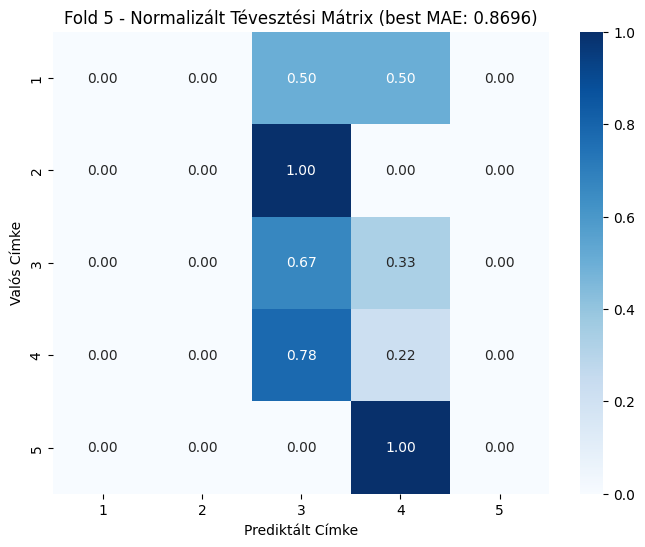


K-Fold MAE-k (HuBERT + CosineScheduler + ExpectedValue): [0.8333333333333334, 0.75, 0.875, 0.75, 0.8695652173913043]
Átlagos MAE (fold átlag): 0.8155797101449276


In [7]:
# 7. 5-Fold Stratified Cross-Validation Ensemble (HuBERT, régi recept + diagnosztika)
from sklearn.model_selection import StratifiedKFold
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

KFOLDS = 5
EPOCHS_KF = 8
PATIENCE_KF = 3
LEARNING_RATE_KF = 1e-5

def coral_probs_to_label_expected(probs):
    B = probs.size(0)
    ones = torch.ones(B, 1, device=probs.device)
    zeros = torch.zeros(B, 1, device=probs.device)
    p_gt = torch.cat([ones, probs, zeros], dim=1)
    p_exact = p_gt[:, :-1] - p_gt[:, 1:]
    labels = torch.arange(1, probs.size(1)+2, device=probs.device).float()
    exp_val = torch.sum(p_exact * labels, dim=1)
    return torch.clamp(torch.round(exp_val), 1, probs.size(1)+1).long()

if 'df_processed' in globals() and not df_processed.empty:
    skf = StratifiedKFold(n_splits=KFOLDS, shuffle=True, random_state=SEED)
    labels_all = df_processed['label_int'].values
    fold_results = []

    def coral_loss_simple(probs, labels):
        K = probs.size(1) + 1
        targets = []
        for k in range(1, K):
            target_k = (labels > k).float().unsqueeze(1)
            targets.append(target_k)
        target_tensor = torch.cat(targets, dim=1)
        return nn.BCELoss()(probs, target_tensor)

    for fold, (train_idx, val_idx) in enumerate(skf.split(df_processed, labels_all), start=1):
        print(f'\n[Fold {fold}/{KFOLDS}] Train size={len(train_idx)} Val size={len(val_idx)}')
        df_train_f = df_processed.iloc[train_idx].reset_index(drop=True)
        df_val_f = df_processed.iloc[val_idx].reset_index(drop=True)

        feature_stats_f = {c: (df_train_f[c].mean(), df_train_f[c].std() if df_train_f[c].std() > 0 else 1.0) for c in advanced_feature_cols}

        train_loader_f = create_data_loader(df_train_f, tokenizer, MAX_LEN, BATCH_SIZE, advanced_feature_cols, feature_stats_f)
        val_loader_f = create_data_loader(df_val_f, tokenizer, MAX_LEN, BATCH_SIZE, advanced_feature_cols, feature_stats_f)

        # Fresh model per fold
        model_f = CoralModel(MODEL_NAME, num_classes=NUM_CLASSES, extra_feat_dim=len(advanced_feature_cols)).to(DEVICE)
        optimizer_f = torch.optim.AdamW(model_f.parameters(), lr=LEARNING_RATE_KF)
        # JAVÍTÁS: A scheduler T_0 periódusa az epoch-ok számához kötve
        scheduler_f = CosineAnnealingWarmRestarts(optimizer_f, T_0=EPOCHS_KF, T_mult=1, eta_min=1e-7)

        best_mae_f = float('inf')
        epochs_no_improve = 0

        for epoch in range(EPOCHS_KF):
            model_f.train(); train_losses=[]
            for batch in train_loader_f:
                ids = batch['input_ids'].to(DEVICE)
                mask = batch['attention_mask'].to(DEVICE)
                feats = batch['features'].to(DEVICE) if batch['features'] is not None else None
                labels = batch['labels'].to(DEVICE)

                probs, _ = model_f(ids, mask, extra_feats=feats)
                loss = coral_loss_simple(probs, labels)
                train_losses.append(loss.item())

                loss.backward()
                nn.utils.clip_grad_norm_(model_f.parameters(), 1.0)
                optimizer_f.step()
                optimizer_f.zero_grad()

            # JAVÍTÁS: A scheduler léptetése az epoch végén
            scheduler_f.step()

            # Validation
            model_f.eval(); all_lab=[]; all_pred=[]; val_losses=[]
            with torch.no_grad():
                for batch in val_loader_f:
                    ids = batch['input_ids'].to(DEVICE)
                    mask = batch['attention_mask'].to(DEVICE)
                    feats = batch['features'].to(DEVICE) if batch['features'] is not None else None
                    labels = batch['labels'].to(DEVICE)

                    probs, _ = model_f(ids, mask, extra_feats=feats)
                    l = coral_loss_simple(probs, labels)
                    val_losses.append(l.item())

                    preds = coral_probs_to_label_expected(probs)

                    all_lab.extend(labels.cpu().numpy())
                    all_pred.extend(preds.cpu().numpy())

            mae_f = mean_absolute_error(all_lab, all_pred)
            qwk_f = cohen_kappa_score(all_lab, all_pred, weights='quadratic')
            print(f'Fold {fold} Epoch {epoch+1}: TrainLoss={np.mean(train_losses):.4f} ValLoss={np.mean(val_losses):.4f} ValMAE={mae_f:.4f} QWK={qwk_f:.4f}')

            if mae_f < best_mae_f:
                best_mae_f = mae_f
                epochs_no_improve = 0
                torch.save(model_f.state_dict(), f'coral_fold{fold}_hubert.bin')
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= PATIENCE_KF:
                    print('Early stopping fold', fold)
                    break

        print(f'Fold {fold} best MAE: {best_mae_f:.4f}')
        fold_results.append(best_mae_f)

        # --- Tévesztési mátrix ---
        best_model_fold = CoralModel(MODEL_NAME, num_classes=NUM_CLASSES, extra_feat_dim=len(advanced_feature_cols))
        best_model_fold.load_state_dict(torch.load(f'coral_fold{fold}_hubert.bin'))
        best_model_fold.to(DEVICE)
        best_model_fold.eval()
        all_lab_best=[]; all_pred_best=[]
        with torch.no_grad():
            for batch in val_loader_f:
                ids = batch['input_ids'].to(DEVICE)
                mask = batch['attention_mask'].to(DEVICE)
                feats = batch['features'].to(DEVICE) if batch['features'] is not None else None
                labels = batch['labels'].to(DEVICE)
                probs, _ = best_model_fold(ids, mask, extra_feats=feats)
                preds = coral_probs_to_label_expected(probs)
                all_lab_best.extend(labels.cpu().numpy())
                all_pred_best.extend(preds.cpu().numpy())
        cm = confusion_matrix(all_lab_best, all_pred_best, labels=list(range(1, NUM_CLASSES + 1)))
        cm_norm = (cm.T / cm.sum(axis=1)).T
        plt.figure(figsize=(8,6))
        sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=list(range(1, NUM_CLASSES+1)), yticklabels=list(range(1, NUM_CLASSES+1)))
        plt.title(f'Fold {fold} - Normalizált Tévesztési Mátrix (best MAE: {best_mae_f:.4f})')
        plt.xlabel('Prediktált Címke'); plt.ylabel('Valós Címke')
        plt.show()

    mean_mae = np.mean(fold_results)
    print('\nK-Fold MAE-k (HuBERT + CosineScheduler + ExpectedValue):', fold_results)
    print('Átlagos MAE (fold átlag):', mean_mae)
else:
    print('Nincs adat a K-fold futtatásához.')